In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
%matplotlib inline

from collections import Counter

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
# read in full df
reviews_df = pd.read_pickle("./data/final_reviews.pkl")

In [11]:
reviews_df

,text,funny or not
0,Apparently Prides Osteria had a rough summer a...,0
1,This store is pretty good. Not as great as Wal...,0
2,I called WVM on the recommendation of a couple...,0
3,I've stayed at many Marriott and Renaissance M...,0
4,The food is always great here. The service fro...,0
...,...,...
8635398,"In December, I called in (as a returning custo...",0
8635399,This guy is a moron that will stalk and harass...,0
8635400,"Yummy, great chew on the bagel\nFriendly staff...",1
8635401,This used to be my car wash of choice. They di...,0


### Text Pre-processing

In [12]:
import re

REPLACE_BY_SPACE_RE = re.compile('[/{}\[\]\|@]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

In [13]:
## function for cleaning text

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    # text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    # text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('\n', '')
    # text = re.sub(r'\W+', '', text)
    # text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    return text

In [14]:
reviews_df.text = reviews_df.text.apply(clean_text)

In [20]:
reviews_df.text.iloc[15]

"Quickly stopped in for a UFC fight. I sat down at the bar while my boyfriend parked the car. Although the restaurant bar was packed and LOUD, the bartender  (Vanessa) came over within a minute. Prompt service with a smile. When my boyfriend arrived a few minutes later, we didn't see Vanessa behind the bar so we tried to flag down her male coworker. He was caught up watching the fight and it took a few minutes to get his attention - which is fine. Not fine, however, is that after I ordered a beer, he stood and texted for a few minutes before getting my beer and held his arm up to shield his texting from management lol. Vanessa, however, is an excellent bartender!! As loud as it is in this place, she continually scanned the bar looking for people attempting to make eye contact with her for service. I watched her work (my boyfriend and I have thirty years of food and beverage experience between the two of us) and she was focused and productive, but most importantly, she was ATTENTIVE! Gi

### Tokenization ##

In [21]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 200

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
tokenizer.fit_on_texts(reviews_df.text.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 1218613 unique tokens.


In [251]:
from collections import Counter
dict(Counter(word_index).most_common(20))

{'establishmentcute': 1218613,
 'bagelfriendly': 1218612,
 'bchhf': 1218611,
 'chocolatetine': 1218610,
 'flavorlesssomehow': 1218609,
 'fernada': 1218608,
 'sanitaizer': 1218607,
 'ordersonline': 1218606,
 'züricher': 1218605,
 'deoxidizing': 1218604,
 "cynosure's": 1218603,
 'piaugier': 1218602,
 'trepidating': 1218601,
 '整个社区都会沦陷，希望大家近期去过那边吃饭的人有没有症状都去检查一下，如果患上了就做个自我隔离。': 1218600,
 '美国现在完全是打算让全民免疫自我修复，被告知得了新冠，检测机构部门那边只让我在家里呆够10天，之后就能出门，没有要给你开药也没有说10天后再去检查阴性好了才获准出门，在这10天里完全是靠个人自觉，所以说为什么美国得诊人数如此之高，波士顿华人圈子很小，一旦多人感染了': 1218599,
 '用一个破塑料围着桌子，也不知道多久消毒一下看着很脏，如果上一桌感染了的人在里面用过下一桌的人必染无疑！因为你进出都会碰到那块塑料，希望最近有去过那边堂吃的人去做一个检测看看有没有人跟我一样得了的最后我想说一下': 1218598,
 '的人': 1218597,
 '完全没有卫生局要求每个桌子应该隔离一定的距离，基本都是连着坐满了，当天店里座位坐满了70': 1218596,
 '我确诊了covid了。我怀疑是在刘一手火锅店里染上的，最近2个月都没有聚会也没有出外用餐或叫外卖，唯独一个星期前怀着侥幸的心理去了刘一手堂吃，我想吐槽一下波士顿刘一手火锅店里面的卫生问题：1火锅底料随便放在公共地方任人拿，而且使用的还是公用勺子！2': 1218595,
 'fanmily': 1218594}

In [22]:
X = tokenizer.texts_to_sequences(reviews_df.text.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (8635403, 200)


In [23]:
y = reviews_df['funny or not'].values
print('Shape of label tensor:', y.shape)

Shape of label tensor: (8635403,)


In [24]:
# train test split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6908322, 200) (6908322,)
(1727081, 200) (1727081,)


In [26]:
# balance train data
X_train_funny = pd.DataFrame(X_train[y_train == 1])
X_train_not_funny = pd.DataFrame(X_train[y_train == 0]).sample(n=len(X_train_funny), random_state=42)

y_train_funny = pd.DataFrame(y_train[y_train == 1])
y_train_not_funny = pd.DataFrame(y_train[y_train == 0]).sample(n=len(y_train_funny), random_state=42)

X_train_balanced = pd.concat([X_train_funny, X_train_not_funny])
y_train_balanced = pd.concat([y_train_funny, y_train_not_funny])

In [27]:
# # save to csv
# X_train_balanced.to_csv('X_train_balanced_tokenized_10000_200.csv')
# y_train_balanced.to_csv('y_train_balanced_tokenized_10000_200.csv')

In [9]:
# # read in csvs
# X_train_balanced = pd.read_csv('X_train_balanced_tokenized_10000_200.csv')
# y_train_balanced = pd.read_csv('y_train_balanced_tokenized_10000_200.csv')

In [11]:
# drop unnamed column
X_train_balanced = X_train_balanced.drop(['Unnamed: 0'], axis = 1)
y_train_balanced = y_train_balanced.drop(['Unnamed: 0'], axis = 1)

In [30]:
# shuffle data 
X_train_balanced = X_train_balanced.sample(frac=1, random_state=42)
y_train_balanced = y_train_balanced.sample(frac=1, random_state=42)

In [ ]:
# take sample of 50k/100k

sample_X_train_balanced = X_train_balanced.sample(n=50000, random_state=42)
sample_y_train_balanced = y_train_balanced.sample(n=50000, random_state=42)

In [51]:
y_train_balanced.value_counts()

0    272931
1    272931
dtype: int64

In [ ]:
# shuffle test data

X_test = pd.DataFrame(X_test).sample(frac=1, random_state=42)
y_test = pd.DataFrame(y_test).sample(frac=1, random_state=42)

### Modeling

#### LSTM with one layer

In [209]:
EMBEDDING_DIM = 100
LSTM_OUT = 100

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(LSTM_OUT, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')])

print(model.summary())

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 200, 100)          1000000   
_________________________________________________________________
spatial_dropout1d_22 (Spatia (None, 200, 100)          0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 101       
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
_________________________________________________________________
None


In [114]:
# train the model on sample of 50k

history = model.fit(sample_X_train_balanced, sample_y_train_balanced, 
                    epochs=3, 
                    batch_size=64,
                    validation_split=0.2,
                    verbose = 1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/3
625/625 [==============================] - 131s 199ms/step - loss: 0.6554 - accuracy: 0.5984 - precision: 0.6043 - recall: 0.5653 - val_loss: 0.5725 - val_accuracy: 0.7104 - val_precision: 0.6901 - val_recall: 0.7625
Epoch 2/3
625/625 [==============================] - 121s 193ms/step - loss: 0.5622 - accuracy: 0.7196 - precision: 0.7266 - recall: 0.7052 - val_loss: 0.5483 - val_accuracy: 0.7269 - val_precision: 0.7457 - val_recall: 0.6876
Epoch 3/3
625/625 [==============================] - 121s 194ms/step - loss: 0.5336 - accuracy: 0.7441 - precision: 0.7551 - recall: 0.7131 - val_loss: 0.5466 - val_accuracy: 0.7280 - val_precision: 0.7703 - val_recall: 0.6488


In [210]:
# make sure to reinstantiate model then train on full data

history = model.fit(X_train_balanced, y_train_balanced, 
                    epochs=4, 
                    batch_size=64,
                    validation_split=0.2,
                    verbose = 1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/4
6824/6824 [==============================] - 1623s 237ms/step - loss: 0.5724 - accuracy: 0.7023 - precision: 0.7028 - recall: 0.7063 - val_loss: 0.5239 - val_accuracy: 0.7435 - val_precision: 0.7388 - val_recall: 0.7538
Epoch 2/4
6824/6824 [==============================] - 1619s 237ms/step - loss: 0.5218 - accuracy: 0.7452 - precision: 0.7424 - recall: 0.7504 - val_loss: 0.5154 - val_accuracy: 0.7467 - val_precision: 0.7643 - val_recall: 0.7138
Epoch 3/4
6824/6824 [==============================] - 1623s 238ms/step - loss: 0.5087 - accuracy: 0.7531 - precision: 0.7516 - recall: 0.7560 - val_loss: 0.5135 - val_accuracy: 0.7507 - val_precision: 0.7424 - val_recall: 0.7679
Epoch 4/4
6824/6824 [==============================] - 1603s 235ms/step - loss: 0.5026 - accuracy: 0.7565 - precision: 0.7562 - recall: 0.7591 - val_loss: 0.5097 - val_accuracy: 0.7497 - val_precision: 0.7519 - val_recall: 0.7455


In [211]:
# save model
model.save('LSTM1.h5')

In [212]:
# save history

hist_df = pd.DataFrame(history.history)

hist = 'history.csv'
with open(hist, mode='w') as f:
    hist_df.to_csv(f)

In [222]:
# evaluate model

scores = model.evaluate(X_test, y_test)

In [60]:
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}\n  Precision: {:0.4}\n  Recall: {:0.4f}'.format(scores[0],scores[1], scores[2], scores[3]))

Test set
  Loss: 0.5067
  Accuracy: 0.7650
  Precision: 0.1133
  Recall: 0.7285


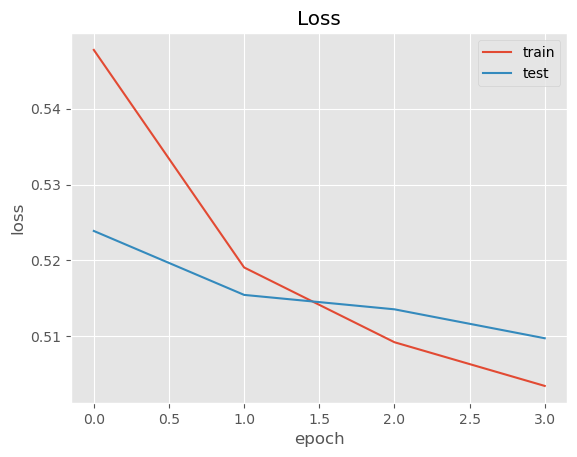

In [233]:
# plot loss

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
#plt.show();
plt.savefig('imgs/LSTM1_loss', bbox_inches='tight')

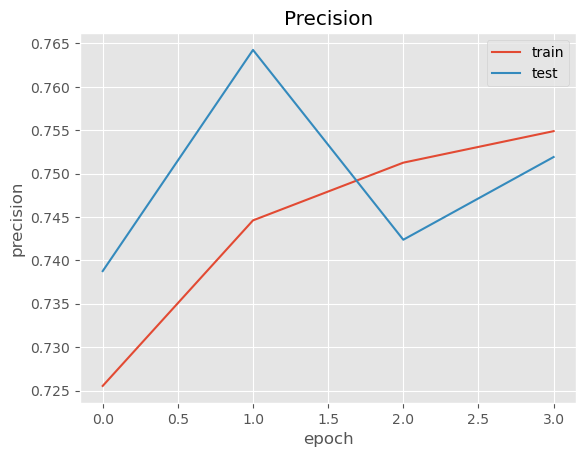

In [234]:
# plot precision

plt.title('Precision')
plt.plot(history.history['precision'], label='train')
plt.plot(history.history['val_precision'], label='test')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend()
#plt.show();
plt.savefig('imgs/LSTM1_precision', bbox_inches='tight')

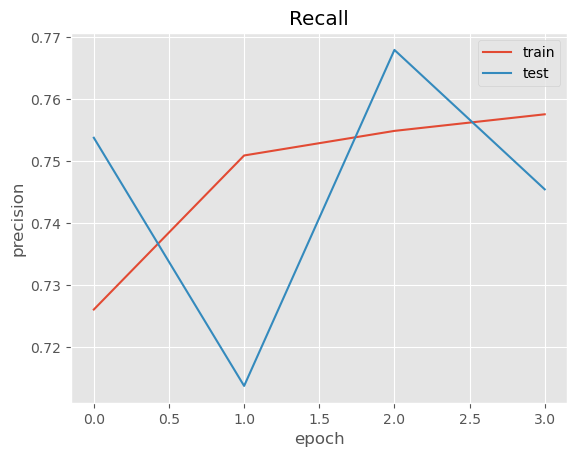

In [235]:
# plot recall

plt.title('Recall')
plt.plot(history.history['recall'], label='train')
plt.plot(history.history['val_recall'], label='test')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend();
#plt.show();
plt.savefig('imgs/LSTM1_recall', bbox_inches='tight')

In [213]:
# get predictions

y_pred_LSTM1 = model.predict_classes(X_test)
#y_proba_LSTM1 = model.predict_proba(X_test)[:, 1]

In [214]:
accuracy = accuracy_score(y_test, y_pred_LSTM1)
precision = precision_score(y_test, y_pred_LSTM1)
recall = recall_score(y_test, y_pred_LSTM1)
print('Accuracy: {:0.4f}\nPrecision: {:0.4}\nRecall: {:0.4f}'.format(accuracy, precision, recall))


Accuracy: 0.7552
Precision: 0.1104
Recall: 0.7397


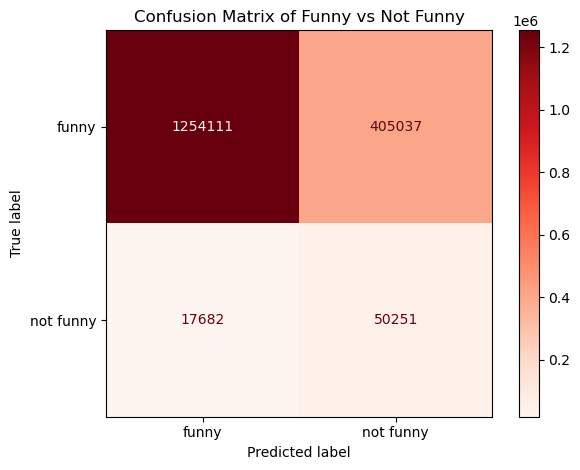

In [216]:
# plot confusion matrix

cm1 = confusion_matrix(y_test, y_pred_LSTM1)

plt.style.use('default')
disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=['funny','not funny'])
disp.plot(cmap='Reds', values_format='')
plt.title('Confusion Matrix of Funny vs Not Funny')
plt.tight_layout()
plt.savefig('imgs/confusion_matrix_LSTM1.png')
plt.show()

#### LSTM with two layers and dropouts

In [202]:
model2 = Sequential()
model2.add(Embedding(10000, 100, input_length=X.shape[1]))
model2.add(SpatialDropout1D(0.4)) # start at 0
model2.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)) # reduce recurrent_dropout later
model2.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
model2.add(Dense(1, activation='sigmoid'))
        
model2.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), 
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

print(model2.summary())

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 200, 100)          1000000   
_________________________________________________________________
spatial_dropout1d_21 (Spatia (None, 200, 100)          0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 200, 100)          80400     
_________________________________________________________________
lstm_26 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 101       
Total params: 1,160,901
Trainable params: 1,160,901
Non-trainable params: 0
_________________________________________________________________
None


In [73]:
# train on sample of 50k

history2 = model2.fit(sample_X_train_balanced, sample_y_train_balanced, 
                    epochs=4, 
                    batch_size=64,
                    validation_split=0.2,
                    verbose = 1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/4
625/625 [==============================] - 245s 381ms/step - loss: 0.6363 - accuracy: 0.6272 - precision: 0.6256 - recall: 0.6333 - val_loss: 0.5738 - val_accuracy: 0.7041 - val_precision: 0.7591 - val_recall: 0.5969
Epoch 2/4
625/625 [==============================] - 236s 377ms/step - loss: 0.5572 - accuracy: 0.7262 - precision: 0.7391 - recall: 0.6949 - val_loss: 0.5472 - val_accuracy: 0.7285 - val_precision: 0.7367 - val_recall: 0.7103
Epoch 3/4
625/625 [==============================] - 235s 376ms/step - loss: 0.5289 - accuracy: 0.7449 - precision: 0.7602 - recall: 0.7213 - val_loss: 0.5472 - val_accuracy: 0.7301 - val_precision: 0.7412 - val_recall: 0.7060
Epoch 4/4
625/625 [==============================] - 235s 376ms/step - loss: 0.5111 - accuracy: 0.7576 - precision: 0.7700 - recall: 0.7438 - val_loss: 0.5424 - val_accuracy: 0.7347 - val_precision: 0.7443 - val_recall: 0.7141


In [203]:
# make sure to reinstantiate model

history2 = model2.fit(X_train_balanced, y_train_balanced, 
                    epochs=3, 
                    batch_size=64,
                    validation_split=0.2,
                    verbose = 1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/3
6824/6824 [==============================] - 3247s 473ms/step - loss: 0.5683 - accuracy: 0.7057 - precision: 0.7007 - recall: 0.7262 - val_loss: 0.5245 - val_accuracy: 0.7426 - val_precision: 0.7395 - val_recall: 0.7495
Epoch 2/3
6824/6824 [==============================] - 3178s 466ms/step - loss: 0.5182 - accuracy: 0.7460 - precision: 0.7452 - recall: 0.7482 - val_loss: 0.5158 - val_accuracy: 0.7487 - val_precision: 0.7534 - val_recall: 0.7395
Epoch 3/3
6824/6824 [==============================] - 3171s 465ms/step - loss: 0.5065 - accuracy: 0.7559 - precision: 0.7558 - recall: 0.7560 - val_loss: 0.5094 - val_accuracy: 0.7508 - val_precision: 0.7431 - val_recall: 0.7668


In [204]:
# save model
model2.save('LSTM2.h5')

In [205]:
# save history

hist2_df = pd.DataFrame(history2.history)

hist2 = 'history2.csv'
with open(hist2, mode='w') as f:
    hist2_df.to_csv(f)

In [220]:
## evaluate model

scores2 = model2.evaluate(X_test, y_test)

53972/53972 [==============================] - 3259s 60ms/step - loss: 0.5189 - accuracy: 0.7379 - precision: 0.1056 - recall: 0.7586


In [223]:
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}\n  Precision: {:0.4}\n  Recall: {:0.4f}'.format(scores2[0],scores2[1], scores2[2], scores2[3]))


Test set
  Loss: 0.5189
  Accuracy: 0.7379
  Precision: 0.1056
  Recall: 0.7586


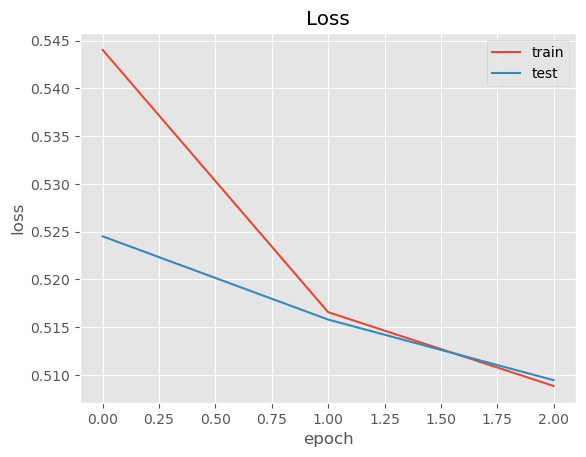

In [236]:
# plot loss

plt.title('Loss')
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend();
#plt.show();
plt.savefig('imgs/LSTM2_loss', bbox_inches='tight')

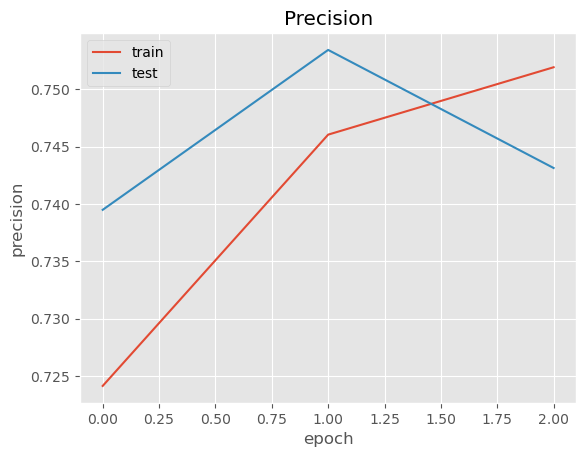

In [237]:
# plot precision

plt.title('Precision')
plt.plot(history2.history['precision'], label='train')
plt.plot(history2.history['val_precision'], label='test')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend();
#plt.show();
plt.savefig('imgs/LSTM2_precision', bbox_inches='tight')

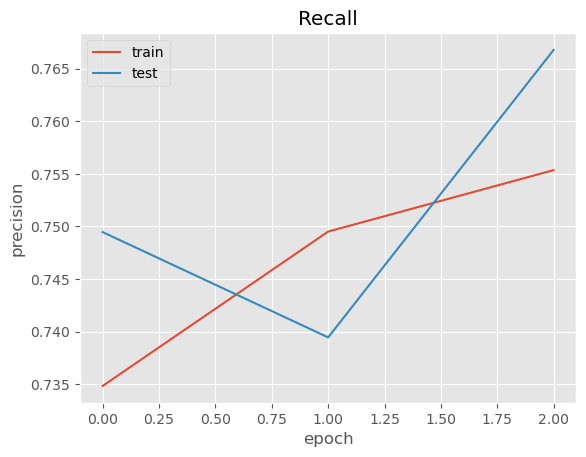

In [238]:
# plot recall

plt.title('Recall')
plt.plot(history2.history['recall'], label='train')
plt.plot(history2.history['val_recall'], label='test')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend();
#plt.show();
plt.savefig('imgs/LSTM2_recall', bbox_inches='tight')

In [206]:
# get predictions

y_pred_LSTM2 = model2.predict_classes(X_test)

In [219]:
accuracy2 = accuracy_score(y_test, y_pred_LSTM2)
precision2 = precision_score(y_test, y_pred_LSTM2)
recall2 = recall_score(y_test, y_pred_LSTM2)
print('Accuracy: {:0.4f}\nPrecision: {:0.4}\nRecall: {:0.4f}'.format(accuracy2, precision2, recall2))


Accuracy: 0.7379
Precision: 0.1056
Recall: 0.7586


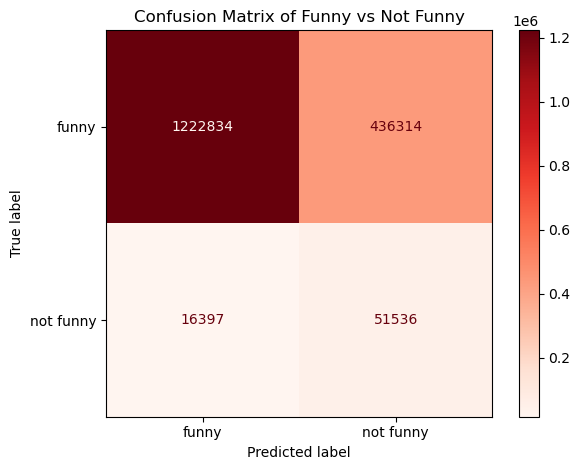

In [217]:
# plot confusion matrix

cm2 = confusion_matrix(y_test, y_pred_LSTM2)

plt.style.use('default')
disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=['funny','not funny'])
disp.plot(cmap='Reds', values_format='')
plt.title('Confusion Matrix of Funny vs Not Funny')
plt.tight_layout()
plt.savefig('imgs/confusion_matrix_LSTM2.png')
plt.show()

#### Bidirectional LSTM layer

In [99]:
# bidirectional LSTM layer

model3 = Sequential()
model3.add(Embedding(10000, 100, input_length=X.shape[1]))
model3.add(SpatialDropout1D(0.4)) # start at 0
model3.add(Bidirectional(LSTM(50))) # bidirectional layer
#model.add(Dropout(0.5))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), 
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

print(model3.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 200, 100)          1000000   
_________________________________________________________________
spatial_dropout1d_10 (Spatia (None, 200, 100)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100)               60400     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 1,060,501
Trainable params: 1,060,501
Non-trainable params: 0
_________________________________________________________________
None


In [95]:
# train on sample of 50k

history_sample_3 = model3.fit(sample_X_train_balanced, sample_y_train_balanced, 
                    epochs=4, 
                    batch_size=64,
                    validation_split=0.2,
                    verbose = 1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
625/625 [==============================] - 87s 131ms/step - loss: 0.6537 - accuracy: 0.6410 - precision: 0.7230 - recall: 0.4575 - val_loss: 0.5753 - val_accuracy: 0.7053 - val_precision: 0.7384 - val_recall: 0.6348
Epoch 2/5
625/625 [==============================] - 70s 112ms/step - loss: 0.5672 - accuracy: 0.7199 - precision: 0.7302 - recall: 0.6935 - val_loss: 0.5516 - val_accuracy: 0.7230 - val_precision: 0.7467 - val_recall: 0.6740
Epoch 3/5
625/625 [==============================] - 67s 108ms/step - loss: 0.5352 - accuracy: 0.7430 - precision: 0.7583 - recall: 0.7158 - val_loss: 0.5410 - val_accuracy: 0.7333 - val_precision: 0.7354 - val_recall: 0.7279
Epoch 4/5
625/625 [==============================] - 69s 110ms/step - loss: 0.5096 - accuracy: 0.7602 - precision: 0.7743 - recall: 0.7373 - val_loss: 0.5396 - val_accuracy: 0.7381 - val_precision: 0.7488 - val_recall: 0.7157
Epoch 5/5
625/625 [==============================] - 69s 110ms/step - loss: 0.4925 - accuracy: 0

In [100]:
# make sure to reinstantiate model

history3 = model3.fit(X_train_balanced, y_train_balanced, 
                    epochs=4, 
                    batch_size=64,
                    validation_split=0.2,
                    verbose = 1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/4
6824/6824 [==============================] - 905s 132ms/step - loss: 0.5734 - accuracy: 0.7035 - precision: 0.7262 - recall: 0.6496 - val_loss: 0.5228 - val_accuracy: 0.7441 - val_precision: 0.7306 - val_recall: 0.7738
Epoch 2/4
6824/6824 [==============================] - 880s 129ms/step - loss: 0.5175 - accuracy: 0.7477 - precision: 0.7536 - recall: 0.7372 - val_loss: 0.5163 - val_accuracy: 0.7458 - val_precision: 0.7388 - val_recall: 0.7609
Epoch 3/4
6824/6824 [==============================] - 870s 128ms/step - loss: 0.5075 - accuracy: 0.7533 - precision: 0.7527 - recall: 0.7544 - val_loss: 0.5127 - val_accuracy: 0.7488 - val_precision: 0.7509 - val_recall: 0.7449
Epoch 4/4
6824/6824 [==============================] - 873s 128ms/step - loss: 0.5031 - accuracy: 0.7558 - precision: 0.7561 - recall: 0.7551 - val_loss: 0.5146 - val_accuracy: 0.7490 - val_precision: 0.7347 - val_recall: 0.7797


In [107]:
# save model
model3.save('BiLSTM.h5')

In [124]:
# save history

hist3_df = pd.DataFrame(history3.history)

hist3 = 'history3.csv'
with open(hist3, mode='w') as f:
    hist3_df.to_csv(f)

In [105]:
# evalute model

scores3 = model3.evaluate(X_test, y_test)

53972/53972 [==============================] - 1112s 21ms/step - loss: 0.5525 - accuracy: 0.7223 - precision: 0.1015 - recall: 0.7720


In [106]:
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}\n  Precision: {:0.4}\n  Recall: {:0.4f}'.format(scores3[0],scores3[1], scores3[2], scores3[3]))

Test set
  Loss: 0.5525
  Accuracy: 0.7223
  Precision: 0.1015
  Recall: 0.7720


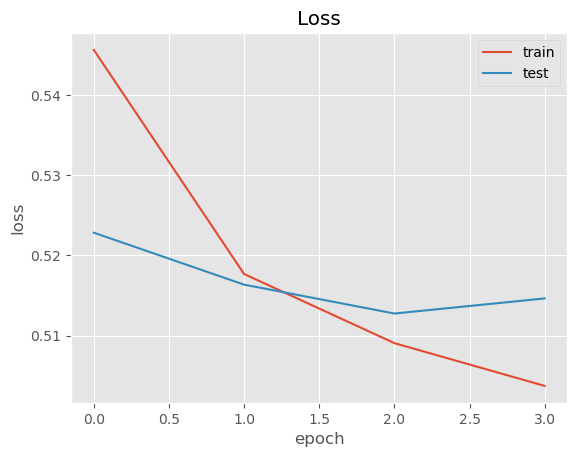

In [239]:
# plot loss

plt.title('Loss')
plt.plot(history3.history['loss'], label='train')
plt.plot(history3.history['val_loss'], label='test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
#plt.show();
plt.savefig('imgs/BiLSTM_loss', bbox_inches='tight')

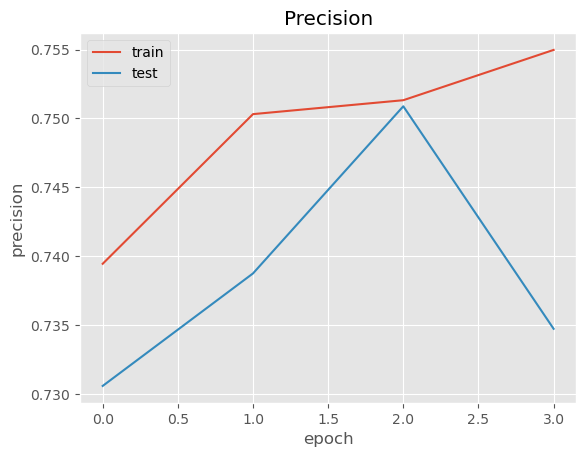

In [240]:
# plot precision

plt.title('Precision')
plt.plot(history3.history['precision'], label='train')
plt.plot(history3.history['val_precision'], label='test')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend()
#plt.show();
plt.savefig('imgs/BiLSTM_precision', bbox_inches='tight')

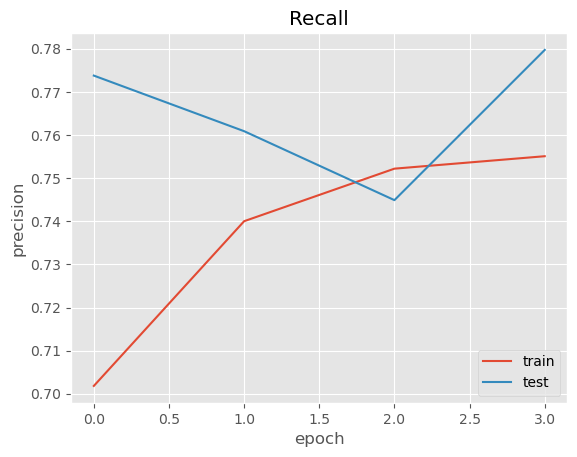

In [241]:
# plot recall

plt.title('Recall')
plt.plot(history3.history['recall'], label='train')
plt.plot(history3.history['val_recall'], label='test')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend()
#plt.show();
plt.savefig('imgs/BiLSTM_recall', bbox_inches='tight')

In [189]:
# get predictions

y_pred = model3.predict_classes(X_test)

In [192]:
accuracy3 = accuracy_score(y_test, y_pred)
precision3 = precision_score(y_test, y_pred)
recall3 = recall_score(y_test, y_pred)
print('Accuracy: {:0.4f}\nPrecision: {:0.4}\nRecall: {:0.4f}'.format(accuracy3, precision3, recall3))


Accuracy: 0.7223
Precision: 0.1015
Recall: 0.7720


In [193]:
# confusion matrix

confusion_matrix(y_test, y_pred)
# true positive, false negative
# false positive, true negative

array([[1194977,  464171],
       [  15487,   52446]])

In [194]:
cm = confusion_matrix(y_test, y_pred)

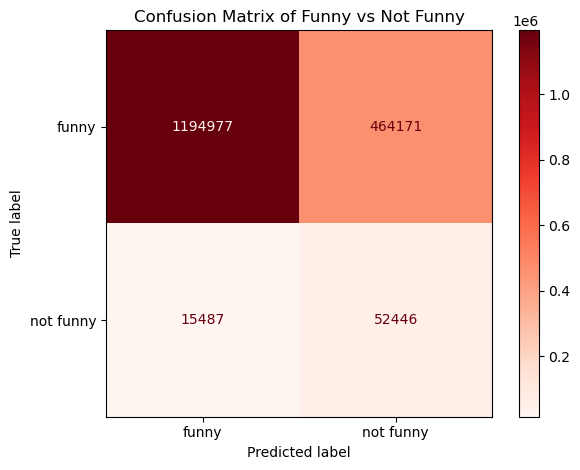

In [218]:
# plot confusion matrix
plt.style.use('default')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['funny','not funny'])
disp.plot(cmap='Reds', values_format='')
plt.title('Confusion Matrix of Funny vs Not Funny')
plt.tight_layout()
plt.savefig('imgs/confusion_matrix_BiLSTM.png')
plt.show()

In [ ]:
df = calculate_threshold_values(y_proba, y_test)

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

plot_precision_recall(ax, df)

In [ ]:
# barplot of model metrics

In [257]:
metric_df = pd.DataFrame({
    'Model': ['Log Reg', 'LSTM 1 layer', 'LSTM 2 layers', 'BiLSTM'],
    'Precision': [0.1064, 0.1104, 0.1056, 0.1015],
    'Recall': [0.7342, 0.7397, 0.7586, 0.7720]
})

In [258]:
metric_df

,Model,Precision,Recall
0,Log Reg,0.1064,0.7342
1,LSTM 1 layer,0.1104,0.7397
2,LSTM 2 layers,0.1056,0.7586
3,BiLSTM,0.1015,0.7720


In [312]:
sns.set_palette('Paired')

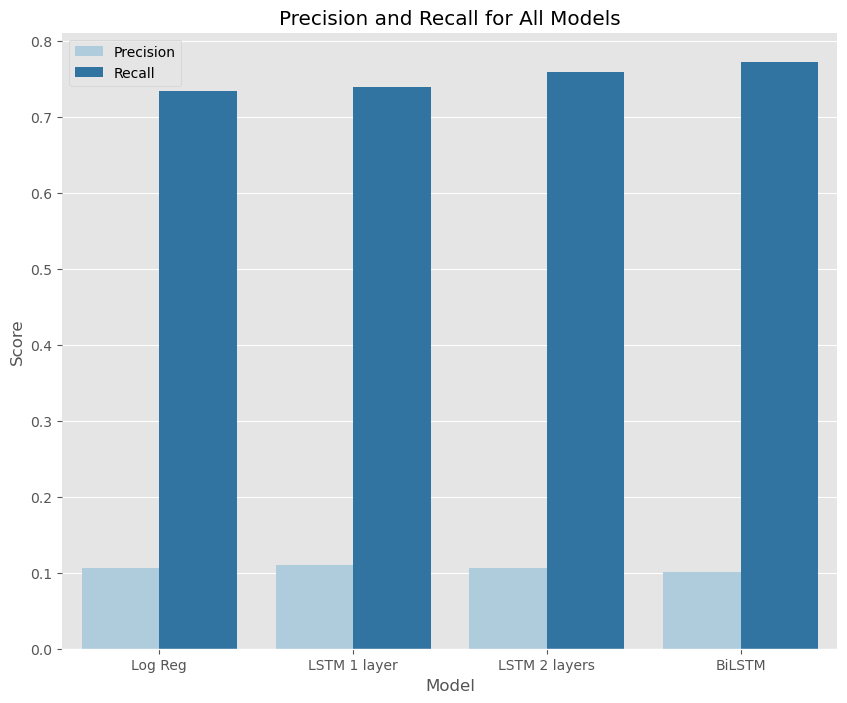

In [327]:
fig, ax = plt.subplots(figsize=(10,8))

data = metric_df.melt('Model', var_name = 'Metric', value_name = 'Score')
sns.barplot(x='Model', y='Score', hue='Metric', data=data, ax=ax)
sns.despine(left=True)
plt.legend(loc='upper left')
plt.title('Precision and Recall for All Models')
plt.savefig('imgs/PR_barchart.png', bbox_inches='tight')

#### To recreate the best model using class:

In [ ]:
import sys, importlib
importlib.reload(sys.modules['src.LSTM'])
importlib.reload(sys.modules['src.BiLSTM'])
from src.LSTM import *
from src.BiLSTM import *

In [224]:
class BiLSTM_model:
    def __init__(self):
        self.model = None
        self.history = []

    def build_model(self, X, MAX_NB_WORDS, EMBEDDING_DIM, LSTM_OUT, optimizer):
        print('>> Building model...')
        model = Sequential()
        model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
        model.add(SpatialDropout1D(0.4)) # start at 0
        model.add(Bidirectional(LSTM(LSTM_OUT))) # bidirectional layer
        #model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))
        
        model.compile(loss='binary_crossentropy', optimizer=optimizer, 
            metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')])
        print('>> Compiled...')

        self.model = model
        return self.model

    def fit(self, X_train, y_train, batch_size=64, epochs=4, validation_split=0.20):
        start_time = time()
        print('>> Fitting model...')

        self.history = self.model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_split=validation_split,
                    verbose = 1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

        elapsed_time = time() - start_time
        print('>> Completed')
        print('>> Training duration (s): {0}'.format(elapsed_time))
        return self.model

    def evaluate(self, X_test, y_test):
        scores = self.model.evaluate(X_test, y_test)
        print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}\n  Precision: {:0.4}\n  Recall: {:0.4f}'.format(scores[0],scores[1], scores[2], scores[3]))

    def plot_cm(self, X_test, y_test):
        y_pred = self.model.predict_classes(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        print('Accuracy: {:0.4f}\nPrecision: {:0.4}\nRecall: {:0.4f}'.format(accuracy, precision, recall))

        cm = confusion_matrix(y_test, y_pred)

        # plot confusion matrix
        plt.style.use('default')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['funny','not funny'])
        disp.plot(cmap='Spectral_r', values_format='')
        plt.title('Confusion Matrix of Funny vs Not Funny')
        plt.tight_layout()
        #plt.savefig('confusion_matrix.png')
        plt.show()

    def plot_recall(self):
        plt.title('Recall')
        plt.plot(self.history.history['recall'], label='train')
        plt.plot(self.history.history['val_recall'], label='test')
        plt.ylabel('recall')
        plt.xlabel('epoch')
        plt.legend()
       #plt.savefig('model_recall.png')
        plt.show()

In [181]:
biLSTM = BiLSTM_model()
biLSTM.build_model(X, 10000, 100, 100, optimizer=Adam(lr=0.0001))
biLSTM.fit(X_train_balanced, y_train_balanced)
biLSTM.evaluate(X_test, y_test)
biLSTM.plot_cm(X_test, y_test)
biLSTM.plot_recall()